# Generate DEA Hotspots animations <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ls8_nbart_geomedian_annual](https://explorer.sandbox.dea.ga.gov.au/ls8_nbart_geomedian_annual)


## Description
This notebook loads DEA Hotspots data for a given time and location, and animates the data over a 2018 Geomedian underlay with fading colours that represent the age of the hotspot.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

In [ ]:
!pip install dea_tools

### Load packages

In [65]:
import os
import datacube
import pandas as pd
import geopandas as gpd
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

import sys
# sys.path.append('../Scripts')
# from dea_spatialtools import xr_rasterize

from dea_tools.spatial import xr_rasterize

# # Create custom cmap with dark grey at end 
fires_cmap = get_cmap('YlOrRd')
fires_cmap.set_over('#1a0f08')

dc = datacube.Datacube(app="DEA_hotspots")

# boundary = gpd.read_file('https://data.gov.au/geoserver/nsw-state-boundary/wfs?request=GetFeature&typeName=ckan_a1b278b1_59ef_4dea_8468_50eb09967f18&outputFormat=json')
boundary = gpd.read_file('https://raw.githubusercontent.com/rowanhogan/australian-states/master/states.geojson').simplify(tolerance=0.02)




/tmp/ipykernel_266/200246866.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  fires_cmap = get_cmap('YlOrRd')


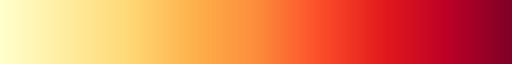

In [66]:
fires_cmap

## Parameters

Set parameters used to load and visualise DEA Hotspots data

In [67]:
# # Setup params
# name = 'actfire'  # name used for output files
# time_period = 15  # days from current date to include in animation (e.g. a month or week of data)
# to_date = (dt.datetime.today() + dt.timedelta(days=1)).strftime('%Y-%m-%d')
# from_date = (dt.datetime.today() - dt.timedelta(days=time_period)).strftime('%Y-%m-%d')
# y_max, x_min = -35.38, 148.68  # top left coordinates of bbox
# y_min, x_max = -36.02, 149.32  # bottom right coordinates of bbox
# min_confidence = 0  # minimum confidence value of hotspots to include in animation
# max_features = 900000  # maximum features to load from WFS
# avhrr=False

# Setup params
name = 'eastcoast'  # name used for output files
from_date = '2019-09-01'
to_date = '2020-02-15'
y_max, x_min = -27.00, 142.5  # top left coordinates of bbox
y_min, x_max = -39.2, 154.7  # bottom right coordinates of bbox
min_confidence = 49  # minimum confidence value of hotspots to include in animation
max_features = 3000000  # maximum features to load from WFS
avhrr=False
modis=True
viirs=True

# Setup params
name = 'tiwi'  # name used for output files
from_date = '2020-08-25'
to_date = '2020-09-01'
y_max, x_min = -11.363076, 129.892554  # top left coordinates of bbox
y_min, x_max = -11.980380, 130.936255  # bottom right coordinates of bbox
min_confidence = 49  # minimum confidence value of hotspots to include in animation
max_features = 3000000  # maximum features to load from WFS
avhrr=False
modis=True
viirs=True

# Setup params
name = 'nt'  # name used for output files
from_date = '2023-09-25'
to_date = '2023-10-12'
y_max, x_min = -20.00, 130.30
y_min, x_max = -23.6, 134.00
min_confidence = 40  # minimum confidence value of hotspots to include in animation
max_features = 3000000  # maximum features to load from WFS
ahi=True
# ahi=False
avhrr=True
modis=True
viirs=True

# Visualisation params
frame_freq = '1H'  # frequency used to generate animation frames (e.g. one frame every 3 hours). Smaller numbers create longer, smoother animations but take longer to render
hotspots_markersize = 5  # size to plot hotspots on map
hotspots_alpha = 1  # transperancy to plot hotspots on map
fade_hours = 72  # hours used to fade hotspots from yellow to black
geomedian_res = 0.005  # resolution in degrees to load geomedian underlay (smaller = slower rendering)

## Load and clean hotspots data

In [48]:
# Load WFS query data
ahi_string = '(sensor=%27AHI%27%20AND%20(product=%27BRIGHT%20AHI%27))%20OR%20' if ahi else ''
avhrr_string = '(sensor=%27AVHRR%27%20AND%20(product=%27SRSS%27))%20OR%20' if avhrr else ''
modis_string = '(sensor=%27MODIS%27%20AND%20(product=%27MOD14%27))%20OR%20' if modis else ''
viirs_string = '(sensor=%27VIIRS%27%20AND%20(product=%27AFMOD%27%20OR%20product=%27EDR%27))' if viirs else ''
url = f"https://hotspots.dea.ga.gov.au/geoserver/public/wfs?service=WFS&version=1.1.0&request=GetFeature&typeName=public:hotspots&outputFormat=application/json&CQL_FILTER=({ahi_string}{avhrr_string}{modis_string}{viirs_string})%20AND%20datetime%20%3E%20%27{from_date}%27%20AND%20datetime%20%3C%20%27{to_date}%27%20AND%20INTERSECTS(location,%20POLYGON(({y_min}%20{x_min},%20{y_min}%20{x_max},%20{y_max}%20{x_max},%20{y_max}%20{x_min},%20{y_min}%20{x_min})))&maxFeatures={max_features}&startIndex=0&sortBy=sensor%20A"
hotspots_gdf = gpd.read_file(url)

<Axes: >

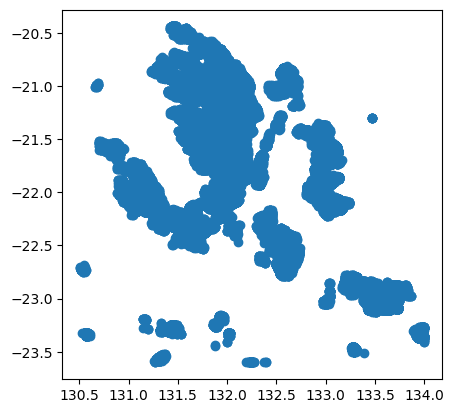

In [49]:
# Filter by confidence
hotspots_gdf = hotspots_gdf.loc[hotspots_gdf.confidence >= min_confidence]

# Fix datetime
hotspots_gdf['datetime'] = pd.to_datetime(hotspots_gdf['start_dt'])

# Extract required columns
hotspots_gdf = hotspots_gdf.loc[:, [
    'datetime', 'latitude', 'longitude', 'confidence', 'geometry'
]]
hotspots_gdf.sort_values('datetime', ascending=True, inplace=True)
hotspots_gdf.plot()

## Load geomedian underlay

In [50]:
# Create a query object
query = {
    "time": '2022',
    "x": (x_min, x_max),
    "y": (y_max, y_min),
    "measurements": ["red", "green", "blue"],
    "output_crs": "EPSG:4326",
    "resolution": (-geomedian_res, geomedian_res),
}

ds = dc.load(product="ga_ls8c_nbart_gm_cyear_3", **query)

# boundary_xr = xr_rasterize(gdf=boundary, 
#              da=ds.red, 
#              x_dim='longitude', 
#              y_dim='latitude',
#              all_touched=True)

# ds = ds.where(boundary_xr, other=0)


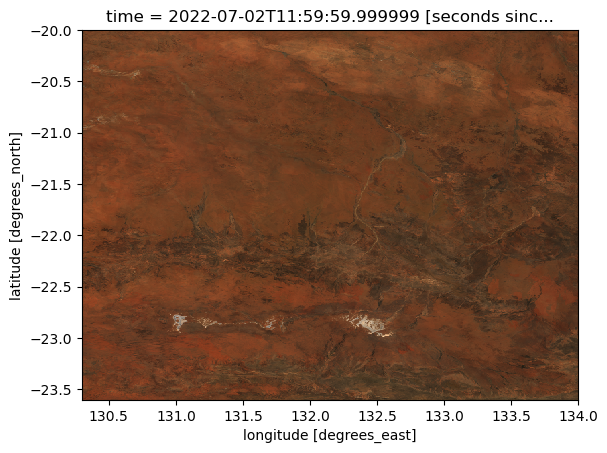

In [51]:
ds[['red', 'green', 'blue']].isel(time=0).to_array().plot.imshow(vmax=4000)
# hotspots_gdf.plot(ax=plt.gca(), column='datetime', cmap=fires_cmap)

## Generate animation frames

/env/lib/python3.8/site-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


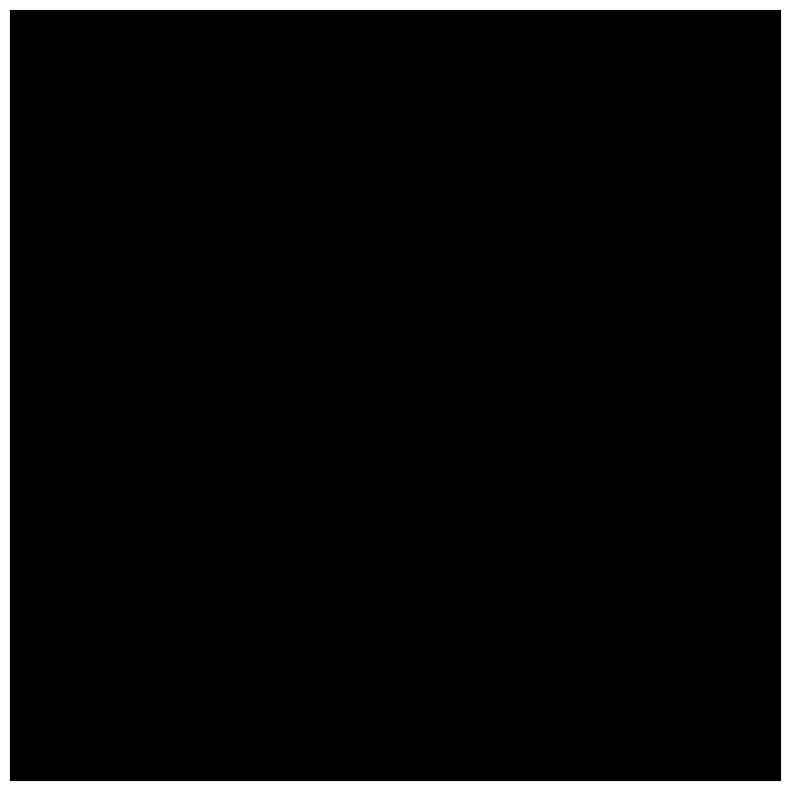

In [68]:
ds_ani = ds.copy(deep=True)

# If output folder doesn't exist, create it
output_dir = f'frames_{name}'
os.makedirs(output_dir, exist_ok=True)

# # Get date/times to iterate through (1 per frame)
# comp_dates = pd.date_range(hotspots_gdf.datetime.min(), 
#                            (dt.datetime.today() + dt.timedelta(days=0.7)), 
#                            freq=frame_freq)

# Get date/times to iterate through (1 per frame)
comp_dates = pd.date_range(from_date, 
                           to_date, 
                           freq=frame_freq)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for i, comp_date in enumerate(comp_dates):
    
    comp_date = comp_date.tz_localize(None)

    # Extract only hotspots occuring prior to frame date/time
    hotspots_prev = hotspots_gdf.loc[
        hotspots_gdf['datetime'].dt.tz_localize(None) < comp_date].copy()
    
    # Calculate hours between frame date and hotspot and sort
    hotspots_prev['hours_before'] = ((
        (comp_date - hotspots_prev['datetime'].dt.tz_localize(None))).astype('timedelta64[m]') / 60)
    hotspots_prev.sort_values('hours_before', inplace=True, ascending=False)
    
    # Filter to most recent hours
    # hotspots_prev = hotspots_prev[hotspots_prev.hours_before < fade_hours]

#     # Plot Geomedian as underlay
#     try:
#         burnt_pixels = xr_rasterize(gdf=hotspots_prev, 
#                                         da=ds_ani.red, 
#                                         all_touched=True)
#         ds_ani = ds_ani * (1 - burnt_pixels * 0.05)
#     except:
#         pass
    
    ds_ani[['red', 'green', 'blue']].isel(time=0).to_array().plot.imshow(ax=ax, 
                                                                     vmax=4000)
    
    # Plot hotspots
    hotspots_prev.plot(ax=ax,
                       column='hours_before',
                       cmap=fires_cmap,
                       markersize=hotspots_markersize,
                       alpha=hotspots_alpha,
                       vmin=0,
                       vmax=fade_hours,
                       aspect=1,
                      )
    
#     boundary.plot(linestyle=':', edgecolor='white', facecolor='none', ax=plt.gca())
    
#     labels = {'Sydney': (151.2093, -33.8688), 
#               'Canberra': (149.1300, -35.2809), 
#               'Melbourne': (144.9631, -37.8136)}

#     for label, (x, y) in labels.items():
#         plt.annotate(s=label,
#                          xy=(x + 0.25, y), 
#                          c='white',
#                          fontname='Liberation Sans',
#                          fontsize=10), 
    
    # Customise plot and add title
    ax.set_facecolor('black')
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('');
    ax.text(0.03, 0.95,
            f"{comp_date.tz_localize(tz='UTC').tz_convert('Australia/Sydney'):%Y-%m-%d}",
            ha='left', 
            va='center', 
            transform=ax.transAxes,
           fontdict={'fontsize': 20, 
                     'color': 'white', 
                     # 'fontname':'Liberation Sans',
                    })
    
    # Export frame to file
    fig.savefig(f'{output_dir}/hotspots_{i}.png', 
#                 bbox_inches='tight',
#                 dpi=100,
#                 pad_inches=0
               )
    plt.cla()


## Combine into MP4 animation using FFMPEG

In [69]:
!ffmpeg -y -r 24 -i $output_dir/hotspots_%d.png -c:v libx264 -vf crop=in_w-2:in_h-2 -pix_fmt yuv420p $output_dir/hotspots_animation.mp4

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 11.3.0 (conda-forge gcc 11.3.0-19)
  configuration: --prefix=/env --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-gnutls --enable-libmp3lame --enable-libvpx --enable-pthreads --enable-vaapi --enable-gpl --enable-libx264 --enable-libx265 --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-pic --enable-shared --disable-static --enable-version3 --enable-zlib -

In [ ]:
!ffmpeg -y -r 24 -i $output_dir/hotspots_%d.png -vf crop=in_w-15:in_h-15,minterpolate=fps=7 $output_dir/hotspots_animation.gif

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** January 2020

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)